# WAMECU Anomaly Detection Notebook

This notebook extends the prototype simulation by applying statistical tests to synthetic draws. We examine how chi-square and entropy diagnostics react when bias is present in the WAMECU coefficients.

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("seaborn-v0_8")

project_root = Path().resolve()
for candidate in {project_root / "src", project_root.parent / "src"}:
    if candidate.exists() and str(candidate) not in sys.path:
        sys.path.append(str(candidate))

from wamecu import (
    chi_square_statistic,
    entropy_gap,
    simulate_draws,
    wamecu_probabilities,
)


## 1. Generate Synthetic Draws

We reuse the six-outcome system from the prototype. The bias vector amplifies the first outcome and suppresses the final outcome, mimicking a skewed die.

In [2]:
n_outcomes = 6
beta = np.array([0.08, 0.02, -0.01, -0.02, 0.0, -0.07])
probabilities = wamecu_probabilities(n_outcomes, beta)
n_trials = 20000
outcomes = simulate_draws(probabilities, n_trials, seed=123)
counts = pd.Series(outcomes).value_counts().sort_index().rename('observed')
expected = pd.Series(probabilities * n_trials, name='expected')
summary = pd.concat([counts, expected], axis=1)
summary['deviation'] = summary['observed'] - summary['expected']
summary

,observed,expected,deviation
0,3593,3600.000000,-7.000000
1,3426,3400.000000,26.000000
2,3313,3300.000000,13.000000
3,3387,3266.666667,120.333333
4,3230,3333.333333,-103.333333
5,3051,3100.000000,-49.000000


## 2. Visualize the Bias

The bar chart emphasizes where the empirical counts deviate from expectation.

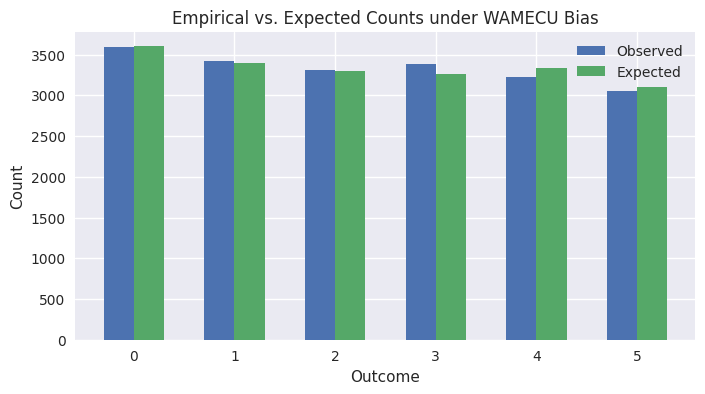

In [3]:
fig, ax = plt.subplots(figsize=(8, 4))
index = np.arange(n_outcomes)
ax.bar(index - 0.15, summary['observed'], width=0.3, label="Observed", color="#4C72B0")
ax.bar(index + 0.15, summary['expected'], width=0.3, label="Expected", color="#55A868")
ax.set_xlabel("Outcome")
ax.set_ylabel("Count")
ax.set_title("Empirical vs. Expected Counts under WAMECU Bias")
ax.set_xticks(index)
ax.legend()
plt.show()


## 3. Chi-square Test

A chi-square goodness-of-fit test quantifies the probability that the observed counts arose from the unbiased baseline distribution.

In [4]:
baseline_prob = np.full(n_outcomes, 1.0 / n_outcomes)
expected_baseline = baseline_prob * n_trials
chi2_stat, chi2_p = chi_square_statistic(summary['observed'].values, expected_baseline)
chi2_stat, chi2_p

(50.90920000000001, 9.02720231898968e-10)

A small p-value indicates that the unbiased baseline is implausible. Here the test rejects the null hypothesis, signalling detectable bias in the draws.

## 4. Entropy Diagnostics

Entropy measures disorder in the distribution. Comparing the empirical entropy to the unbiased baseline reveals whether the system exhibits additional structure (lower entropy) or noise (higher entropy).

In [5]:
empirical_prob = summary['observed'].values / n_trials
entropy_difference = entropy_gap(empirical_prob, baseline_prob)
entropy_difference

-0.0018435666532918837

A negative entropy gap means the empirical draws are more concentrated than the uniform baseline, consistent with the chi-square alert. Positive values would indicate higher randomness than expected.